In [1]:
import warnings
warnings.filterwarnings('ignore')

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
#import string
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.model_selection import TimeSeriesSplit
#from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

#from gensim.models import Word2Vec
#from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os


from sklearn import cross_validation
from sklearn.model_selection import TimeSeriesSplit
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.naive_bayes import MultinomialNB

C:\Users\Ram Nikhilesh\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
con = sqlite3.connect(r"C:\Users\Ram Nikhilesh\Desktop\ai class\csv files\td1\database.sqlite")
filtered_data = pd.read_sql_query("""select * from Reviews where Score != 3""",con)
print(filtered_data.shape)
def partition(x):
    if x < 3:
        return 0
    return 1


actualscore=filtered_data['Score']
positivenegative=actualscore.map(partition)
filtered_data['Score']=positivenegative
filtered_data.shape
sorted_data=filtered_data.sort_values('ProductId',axis=0,ascending=True,kind='mergsort',na_position='last')
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace=False)
stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english')

def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr,' ',sentence)
    return cleantext

def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned


    
    
                                                            



(525814, 10)


In [3]:

i=0
str1=' '
final_string=[]
all_positive_words=[]
all_negative_words=[]
s=''
for sent in (final['Text'].values):
    filtered_sentence=[]
    sent=cleanhtml(sent)
        
    for w in sent.split():
        for cleaned_word in cleanpunc(w).split():
            
            if((cleaned_word.isalpha())&(len(cleaned_word) > 2)):
                if((cleaned_word.lower()not in stop)):
                    s=(sno.stem(cleaned_word.lower())).encode('utf-8')
                    filtered_sentence.append(s)
                    if(final['Score'].values)[i]=='positive':
                        all_positive_words.append(s)
                    if(final['Score'].values)[i]=='negative':
                        all_negative_words.append(s)
                else:
                    continue
            else:
                continue
        
    str1=b" ".join(filtered_sentence)
    final_string.append(str1)
    i+=1

In [4]:
final['cleanedText']=final_string
final['cleanedText']=final['cleanedText']
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
conn.close()

In [5]:
if os.path.isfile('final.sqlite'):
    conn=sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")
    
    
  

In [6]:
final_text=final['cleanedText']
score=final['Score']
final_100k=final_text[0:100000]
score_100k=score[0:100000]
tscv=TimeSeriesSplit(n_splits=2,max_train_size=70000)
for train,test in tscv.split(final_100k):
    x_train,x_test=final_100k[train],final_100k[test]
    y_train,y_test=score_100k[train],score_100k[test]
    

In [7]:
count_vector=CountVectorizer()
train_70k=count_vector.fit_transform(x_train)
test_30k=count_vector.transform(x_test)


The optimal alpha is 1.


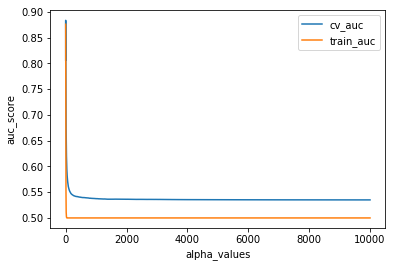

In [27]:

final_score=[]
mylist=list(np.arange(0.0001,10001))
cv_scores=[]

auc_score=[]

for i in mylist:

    mnb=MultinomialNB(alpha=i)
    mnb.fit(train_70k,y_train)
    predict1=mnb.predict(train_70k)
    

    scores = cross_val_score(mnb, train_70k, y_train, cv=4, scoring='roc_auc')
    cv_scores.append(scores.mean())
    
    auc1=metrics.roc_auc_score(y_train, predict1)
    
    auc_score.append(auc1.mean())
    
    
    


mse=[x for x in cv_scores] 
optimal_alpha=mylist[mse.index(max(mse))]
mse2=[y for y in auc_score]
optimal_alpha1=mylist[mse2.index(max(mse2))]
print('\nThe optimal alpha is %d.' % optimal_alpha)
#print('\nThe optimal alpha for train data  is %d.' % optimal_alpha1)
plt.plot(mylist, mse,label="cv_auc")
plt.plot(mylist,mse2,label="train_auc")
plt.xlabel('alpha_values')
plt.ylabel('auc_score')
plt.legend()
plt.show()

    
    
    
    



Test accuracy for k 1 is 91%


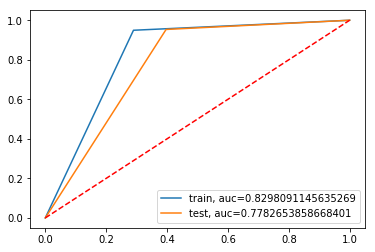

the auc for train data =  0.8298091145635269
the auc for test data =  0.7782653858668401


In [28]:
from sklearn.metrics import accuracy_score
mnb=MultinomialNB(alpha=optimal_alpha)

mnb.fit(train_70k,y_train)
predict=mnb.predict(train_70k)
predict1= mnb.predict(test_30k)
acc = accuracy_score(y_train, predict, normalize=True) * float(100)
print('\nTest accuracy for k %d is %d%%' % (optimal_alpha,acc))
fpr,tpr,_ = metrics.roc_curve(y_train,predict)
fpr1,tpr1,_ = metrics.roc_curve(y_test,predict1)
auc = metrics.roc_auc_score(y_train,predict)
auc2= metrics.roc_auc_score(y_test,predict1)
plt.plot(fpr,tpr,label="train, auc="+str(auc))
plt.plot(fpr1,tpr1,label="test, auc="+str(auc2))
plt.plot([0, 1], [0, 1],'r--')
plt.legend()
plt.show()
print("the auc for train data = ",auc)
print("the auc for test data = ",auc2)

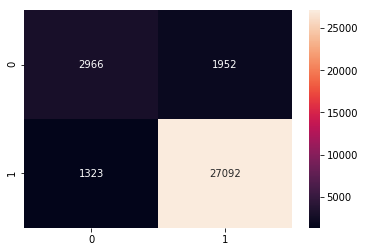

In [29]:
sample=confusion_matrix(y_test,predict1)
ax=sns.heatmap(sample,annot=True,fmt="d")

In [30]:
neg_class=[]
pos_class=[]
neg_class = mnb.feature_log_prob_[0, :].argsort()
pos_class = mnb.feature_log_prob_[1, :].argsort()

print(np.take(count_vector.get_feature_names(), neg_class[-10:]))
print(np.take(count_vector.get_feature_names(), pos_class[-10:]))

['food' 'use' 'flavor' 'tri' 'tea' 'would' 'one' 'product' 'like' 'tast']
['product' 'flavor' 'one' 'great' 'love' 'good' 'use' 'tast' 'like' 'tea']


In [31]:
tfidf_vect=TfidfVectorizer(ngram_range=(1,1))
tf_train70k=tfidf_vect.fit_transform(x_train)
tf_test30k=tfidf_vect.transform(x_test)


The optimal alpha is 1.


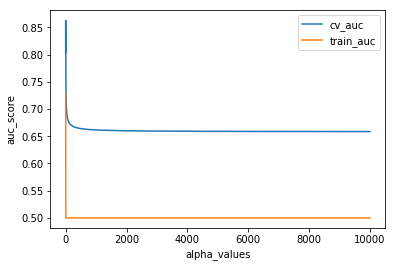

In [32]:

final_score=[]
mylist=list(np.arange(0.0001,10001))
cv_scores=[]
auc_score=[]
for i in mylist:

    mnb=MultinomialNB(alpha=i)
    mnb.fit(tf_train70k,y_train)
    scores = cross_val_score(mnb, tf_train70k, y_train, cv=4, scoring='roc_auc')
    cv_scores.append(scores.mean())
    predict1=mnb.predict(tf_train70k)
    auc1=metrics.roc_auc_score(y_train, predict1)
    
    auc_score.append(auc1.mean())
    
    
    
mse=[x for x in cv_scores] 
optimal_alpha=mylist[mse.index(max(mse))]
mse2=[y for y in auc_score]
optimal_alpha1=mylist[mse2.index(max(mse2))]
print('\nThe optimal alpha is %d.' % optimal_alpha)
#print('\nThe optimal alpha for train data  is %d.' % optimal_alpha1)
plt.plot(mylist, mse,label="cv_auc")
plt.plot(mylist,mse2,label="train_auc")
plt.xlabel('alpha_values')
plt.ylabel('auc_score')
plt.legend()
plt.show()
    
    
    



Test accuracy for k 1 is 85%


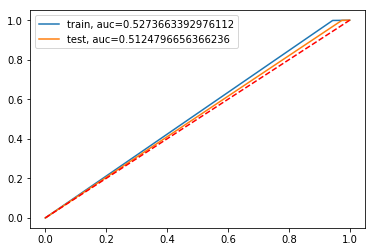

the auc for train data =  0.5273663392976112
the auc for test data =  0.5124796656366236


In [33]:
from sklearn.metrics import accuracy_score
mnb=MultinomialNB(alpha=optimal_alpha)

mnb.fit(tf_train70k,y_train)
predict=mnb.predict(tf_train70k)
predict1= mnb.predict(tf_test30k)
acc = accuracy_score(y_train, predict, normalize=True) * float(100)
print('\nTest accuracy for k %d is %d%%' % (optimal_alpha,acc))
fpr,tpr,_ = metrics.roc_curve(y_train,predict)
fpr1,tpr1,_ = metrics.roc_curve(y_test,predict1)
auc = metrics.roc_auc_score(y_train,predict)
auc2= metrics.roc_auc_score(y_test,predict1)
plt.plot(fpr,tpr,label="train, auc="+str(auc))
plt.plot(fpr1,tpr1,label="test, auc="+str(auc2))
plt.plot([0, 1], [0, 1],'r--')
plt.legend()
plt.show()
print("the auc for train data = ",auc)
print("the auc for test data = ",auc2)

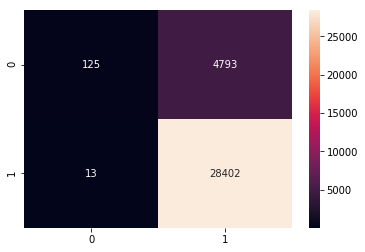

In [34]:
sample=confusion_matrix(y_test,predict1)
ax=sns.heatmap(sample,annot=True,fmt="d") 

In [35]:
neg_class=[]
pos_class=[]
neg_class = mnb.feature_log_prob_[0, :].argsort()
pos_class = mnb.feature_log_prob_[1, :].argsort()

print(np.take(tfidf_vect.get_feature_names(), neg_class[-10:]))
print(np.take(tfidf_vect.get_feature_names(), pos_class[-10:]))

['flavor' 'tri' 'buy' 'order' 'tea' 'one' 'would' 'like' 'product' 'tast']
['one' 'flavor' 'product' 'use' 'like' 'tast' 'good' 'love' 'great' 'tea']


<table>
    <tr>
        <th>model</th>
        <th>optimal alpha</th>
        <th>test accuracy</th>
        <th>sample size</th>
        <th>test size</th>
        <th>test auc</th>
        <th>train auc</th>
    </tr>
    <tr>
        <td>BOW</td>
        <td>9922</td>
        <td>85%</td>
        <td>100k</td>
        <td>30k</td>
        <td>0.778</td>
        <td>0.829</td>
            
    </tr>
    <tr>
        <td>TFIDF</td>
        <td>9999</td>
        <td>85%</td>
        <td>100k</td>
        <td>30k</td>
        <td>0.512</td>
        <td>0.527</td>
    </tr>
</table>    

